In [122]:
import numpy as np
import scipy as sp
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt
import random as rand
import math
def nearest_ind(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#array[idx]

In [2]:
def forwardDif(F, Fnext, delta, k=1):
    return (Fnext - F)/(delta*k)
def backwardDif(F, Fprev, delta, k=1):
    return (F - Fprev)/(delta*k)
def centerDif(Fprev, Fnext, delta, k=1):
    return (Fnext - Fprev)/(2*k*delta)

def center_second(F, Fprev, Fnext, dx):
    return ( Fnext - 2*F + Fprev )/(dx*dx)

# Black-Scholes-Merton

## Define option classes

In [129]:
class Diffusion_Test:
    strike_price = 0.0
    maturity_time = 0.0
    S_MAX = 0.0
    volatility = 0.0
    risk_free_rate = 0.0
    def __init__(self,T,Smax,alpha,K=0,r=0):
        self.strike_price = K
        self.maturity_time = T
        self.S_MAX = Smax 
        self.volatility = alpha
        self.risk_free_rate = r
        
    def Initial_Conds(self,S):
        return (1/(np.pi*np.pi))*math.sin(np.pi*S)
    def Boundary_Conds(self,s):
        if(s==0):
            return 0
        elif(s==self.S_MAX):
            return 0
        else:
            return -1 #THIS SHOULD _NEVER_ BE RETURNED, BUT CAN BE USED AS A FLAG

class European_Long_Call:
    strike_price = 0.0
    maturity_time = 0.0
    S_MAX = 0.0
    volatility = 0.0
    risk_free_rate = 0.0
    def __init__(self,K,T,Smax,sigma,r):
        self.strike_price = K
        self.maturity_time = T
        self.S_MAX = Smax # SHOULD BE MUCH LARGER THAN K
        self.volatility = sigma
        self.risk_free_rate = r
    
    def Initial_Conds(self,S):
        K = self.strike_price
        return np.maximum(S-K,0)
    
    def Boundary_Conds(self,s):
        if(s==0):
            return 0
        elif(s==self.S_MAX):
            return s-self.strike_price
        else:
            return -1 #THIS SHOULD _NEVER_ BE RETURNED, BUT CAN BE USED AS A FLAG
        
    def BSM_sol(self,tau,S): #Takes in time to maturity, aka tau
        sigma,K,r = self.volatility, self.strike_price, self.risk_free_rate
        
        dPlus = ( 1/(sigma*np.sqrt(tau)) )*( np.log(S/K) + (r+sigma*sigma/2)*tau )
        dMinus = dPlus - (sigma*np.sqrt(tau))
        N = lambda s: norm.cdf(s)
        
        return N(dPlus)*(S) - N(dMinus)*K*np.exp(-r*tau)
        

## Explicit Method

In [62]:
# variable substituion: tau = T-t dtau = -dt
# this means we are solving"backwards", the initial condition is the value at maturity
# for now we leave S untransformed, although it probably should be
# since it has a boundary condition enforced at infinity
def Explicit_BSM(Option, N_s, N_t): # 3 arguments
    sigma, r = Option.volatility, Option.risk_free_rate #eqn parameters
    Smax = Option.S_MAX
    S = np.linspace(0,Smax,N_s) #create S grid, will be output
    dS = S[1] - S[0] #find grid spacing
    
    ICs = np.vectorize(Option.Initial_Conds)
    f0 = ICs(S) # returns an array of "initial" f based on option type value at maturity as function of S
    f_of_tau_S = [f0] # this will be the output
    
    T = Option.maturity_time
    TAU = np.linspace(0,T,N_t) #create Tau grid, will be output
    dTau = TAU[1] - TAU[0]
    for j,tau in enumerate(TAU): # begin time loop
        f_of_S_Now = f_of_tau_S[j]
        f_of_S_Next = [] # clear the list to be appended
        for i,s in enumerate(S):
            if(i==0 or i==(N_s-1)): #apply boundary condition at S boundaries
                f_of_S_Next.append(Option.Boundary_Conds(s))
            else:           # if not at boundary, solve dif eq
                fHere = f_of_S_Now[i]
                fNext_S = f_of_S_Now[i+1]
                fPrev_S = f_of_S_Now[i-1]
                
                df_dS = forwardDif(fHere,fNext_S,dS)
                d2f_dS2 = center_second(fHere,fPrev_S,fNext_S,dS)
                
#                 print(dTau*( fHere*r + (sigma*sigma/2)*s*s*d2f_dS2 + r*s*df_dS ) )
                fNext_tau = fHere + dTau*( fHere*r + (sigma*sigma/2)*s*s*d2f_dS2 + r*s*df_dS ) # B-S-M equation
#                 fNext_tau = fHere + dTau*((sigma*sigma/2)*d2f_dS2 ) # heat equation test
                f_of_S_Next.append(fNext_tau)
        f_of_tau_S.append(np.array(f_of_S_Next))
        
    f_of_tau_S = np.array(f_of_tau_S)
    return (TAU,S,f_of_tau_S)

# TESTING

In [130]:
strike_price = .1
S_max = 1
T = 1
sigma = 0.15
r = 0.1
#European_Long_Call(K,T,Smax,sigma,r)
option_test_1 = European_Long_Call(strike_price,T,S_max,sigma,r)


In [71]:
Ns, Nt = 50,5000
print((1/Nt)/(1/(Ns*Ns)))
tau,S,f = Explicit_BSM(option_test_1,Ns,Nt)


0.5


In [ ]:
TAU, Ss = np.meshgrid(tau,S)
exactF = exSol(TAU,Ss)

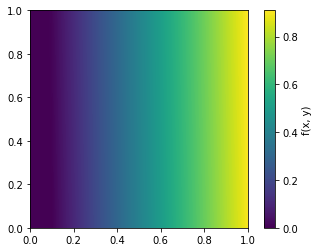

In [134]:
plt.imshow(exactF, extent=[TAU.min(), TAU.max(), Ss.min(), Ss.max()], origin="lower", cmap="viridis")
plt.colorbar(label="f(x, y)")
plt.show()



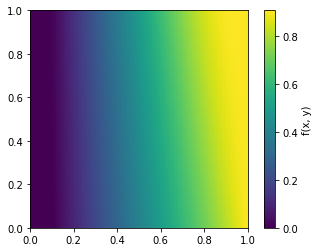

In [135]:
plt.imshow(f, extent=[TAU.min(), TAU.max(), Ss.min(), Ss.max()], origin="lower", cmap="viridis")
plt.colorbar(label="f(x, y)")
plt.show()

4999 2499 0


/tmp/ipykernel_753585/1923709353.py:52: RuntimeWarning: divide by zero encountered in log
  dPlus = ( 1/(sigma*np.sqrt(tau)) )*( np.log(S/K) + (r+sigma*sigma/2)*tau )
/tmp/ipykernel_753585/1923709353.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  dPlus = ( 1/(sigma*np.sqrt(tau)) )*( np.log(S/K) + (r+sigma*sigma/2)*tau )


Text(0.5, 1.0, '$t=0.0$')

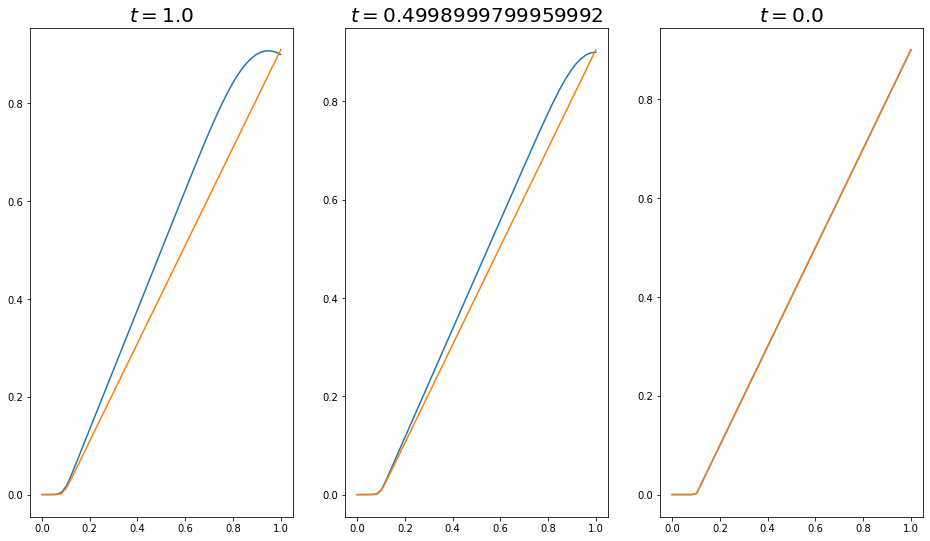

In [132]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))
# t = T - tau
t = tau
ind1,ind2,ind3 = nearest_ind(t,T),nearest_ind(t,T/2),nearest_ind(t,0.)
t1,t2,t3 = t[ind1],t[ind2],t[ind3]
f1,f2,f3 = f[ind1],f[ind2],f[ind3]
exSol = np.vectorize(lambda s,t: option_test_1.BSM_sol(t,s))
sol1,sol2,sol3 = exSol(S,t1), exSol(S,t2), exSol(S,t3)
# xmax = 1
# ymax = S_max - strike_price


ax1.plot(S,f1)
ax1.plot(S,sol1)
ax1.set_title(r'$t={}$'.format(t1),fontsize=20)
# ax1.set_xlim((0,xmax))
# ax1.set_ylim((-ymax,ymax))

ax2.plot(S,f2)
ax2.plot(S,sol2)
ax2.set_title(r'$t={}$'.format(t2),fontsize=20)
# ax2.set_xlim((0,xmax))
# ax2.set_ylim((-ymax,ymax))

ax3.plot(S,f3)
ax3.plot(S,sol3)
ax3.set_title(r'$t={}$'.format(t3),fontsize=20)
# ax3.set_xlim((0,xmax))
# ax3.set_ylim((-ymax,ymax))





/tmp/ipykernel_753585/3395001530.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  dPlus = ( 1/(sigma*np.sqrt(T-t)) )*( np.log(S/K) + (r+sigma*sigma/2)*(T-t) )


array(0.4)

In [ ]:
# diffusion

S_max = 1
T = 1
sqrt_difCoef = np.sqrt(2)/(np.pi)
#European_Long_Call(K,T,Smax,sigma,r)
dif_test = Diffusion_Test(T,S_max,sqrt_difCoef)

In [ ]:
Ns, Nt = 50,5000
print((1/Nt)/(1/Ns)**2)
tau,S,f = Explicit_BSM(dif_test,Ns,Nt)

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,9))
ind1,ind2,ind3 = 0,2500,4999
t = tau
t1,t2,t3 = t[ind1],t[ind2],t[ind3]
f1,f2,f3 = f[ind1],f[ind2],f[ind3]
# xmax = 15
# ymax = S_max - strike_price

##########################

ax1.plot(S,f1)
ax1.set_title(r'$t={}$'.format(t1),fontsize=20)
# ax1.set_xlim((0,xmax))
# ax1.set_ylim((-ymax,ymax))

ax2.plot(S,f2)
ax2.set_title(r'$t={}$'.format(t2),fontsize=20)
# ax2.set_xlim((0,xmax))
# ax2.set_ylim((-ymax,ymax))

ax3.plot(S,f3)
ax3.set_title(r'$t={}$'.format(t3),fontsize=20)
# ax3.set_xlim((0,xmax))
# ax3.set_ylim((-ymax,ymax))



